In [4]:
import rebound
import reboundx
import numpy as np
import sys
import time
import matplotlib.pyplot as plt
%matplotlib inline
from subprocess import call

try:
    plt.style.use('paper')
except:
    print("plot style not found")

In [47]:
dtfactor = 0.080901699437494756
integrator = "whfast"
order = 1
cfac = 1.0
rebxintegrators = ['euler', 'rk2', 'implicit_midpoint']

In [56]:
%%time
Eerr = {}
times = {}

for rebxintegrator in rebxintegrators:
    filename = 'datalobster/GRcfac{0}{1}rebx{2}dt{3:.3e}order{4}'.format(cfac, integrator, rebxintegrator, dtfactor, order)
    print(filename)
    sat = rebound.SimulationArchive(filename+'.sa', rebxfilename=filename+'.rebx')
    sim0 = sat[0]
    P = sim0.particles[1].P
    rebx = reboundx.Extras.from_file(sim0, filename+'.rebx')
    gr = rebx.get_effect("gr")
    E0 = rebx.gr_hamiltonian(sim0, gr)

    Eerr[rebxintegrator], times[rebxintegrator] = np.zeros(sat.nblobs), np.zeros(sat.nblobs)
    for i, sim in enumerate(sat):
        times[rebxintegrator][i] = sim.t/P
        E = rebx.gr_hamiltonian(sim, gr)
        try:
            Eerr[rebxintegrator][i] = np.abs((E-E0)/E0)
        except:
            Eerr[rebxintegrator][i] = 0

datalobster/GRcfac1.0whfastrebxeulerdt8.090e-02order1


/mnt/ssd/workspace/rebound/rebound/simulationarchive.py:83: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/workspace/rebound/rebound/simulationarchive.py:127: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/workspace/rebound/rebound/simulationarchive.py:127: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


datalobster/GRcfac1.0whfastrebxrk2dt8.090e-02order1
datalobster/GRcfac1.0whfastrebximplicit_midpointdt8.090e-02order1
CPU times: user 1.08 s, sys: 261 ms, total: 1.34 s
Wall time: 1.34 s


/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


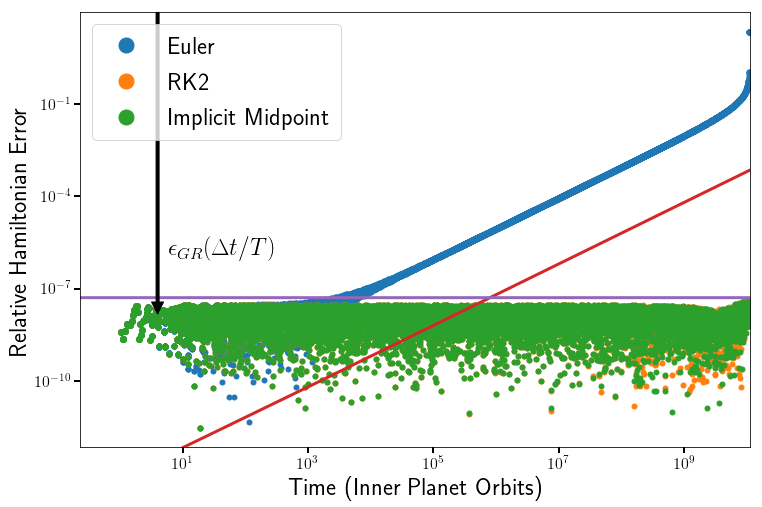

In [61]:
eps = 2.e-7
dt=0.0809
labels = {'euler':'Euler', 'rk2':'RK2', 'implicit_midpoint':'Implicit Midpoint'}
fig, ax = plt.subplots(figsize=(12,8))
for rebxintegrator in rebxintegrators:
    ax.plot(times[rebxintegrator], Eerr[rebxintegrator], '.', label=labels[rebxintegrator], rasterized=True)
t = times['euler']/P
ax.plot(t, (2*np.pi)**2/2*eps**2*dt*t)
ax.plot(t, [np.pi*eps*dt]*len(t))
#ax.plot(t, [np.pi**2/6.*eps*dt**2]*len(t))

ax.set_xscale('log')
ax.set_yscale('log')

plt.rcParams["text.usetex"] =True
plt.locator_params(axis='y', numticks=5)
#plt.locator_params(axis='x', numticks=8)

ax.annotate(text='', xy=(4, 1.5e-8), xytext=(4, ax.get_ylim()[1]), arrowprops=dict(width=3, facecolor='black'))
ax.text(6, 1.e-6, r'$\epsilon_{GR}(\Delta t/T)$', fontsize=24)

ax.legend(fontsize=24, loc='upper left', markerscale=3)
ax.set_xlabel('Time (Inner Planet Orbits)', fontsize=24)
ax.set_ylabel('Relative Hamiltonian Error', fontsize=24)
ax.set_xlim([0, 1.1e10])
fig.savefig("fig2.pdf", bbox_inches='tight')

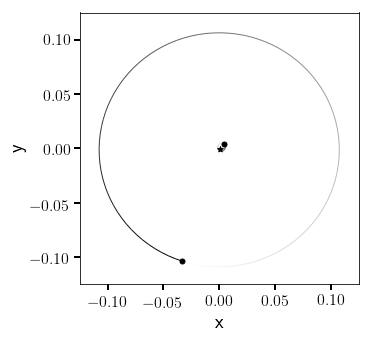

In [35]:
rebxintegrator = 'euler'
filename = 'datalobster/GRcfac{0}{1}rebx{2}dt{3:.3e}order{4}'.format(cfac, integrator, rebxintegrator, dtfactor, order)
sat = rebound.SimulationArchive(filename+'.sa', rebxfilename=filename+'.rebx')
sim0 = sat[0]
P = sim0.particles[1].P
sim = sat.getSimulation(1.074e10*P)
fig = rebound.OrbitPlot(sim)

In [21]:
sim = sat[-1]
sim.t/P

20000000000.073074

20000000000.073074


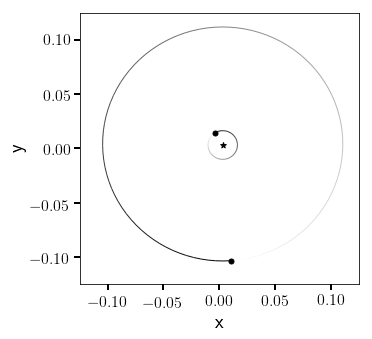

In [14]:
rebxintegrator = 'rk2'
filename = 'datalobster/GRcfac{0}{1}rebx{2}dt{3:.3e}order{4}'.format(cfac, integrator, rebxintegrator, dtfactor, order)
sat = rebound.SimulationArchive(filename+'.sa', rebxfilename=filename+'.rebx')
sim0 = sat[0]
P = sim0.particles[1].P
sim = sat[-1]
print(sim.t/P)
fig = rebound.OrbitPlot(sim)

In [193]:
%%time
from subprocess import call

call('rm -f test*', shell=True)
def epic(dtfactor, integrator):
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=0.93)
    sim.add(m=4.5*3.e-7, P=0.571/365.25, e=0.01)
    sim.add(m=41.*3.e-7, P=13.34/365.25, e=0.01)
    sim.move_to_com()
    sim.integrator=integrator
    sim.dt = dtfactor*sim.particles[1].P
    return sim

def addGR(sim, rebxintegrator, order, cfac):
    rebx = reboundx.Extras(sim)
    gr = rebx.add("gr")
    gr.params["c"] = 63197.8*cfac # AU/yr
    if rebxintegrator != "naive":
        rebx.integrator=rebxintegrator
        gr.operator_order = order 
        gr.force_as_operator = 1
    return rebx

dtfactor=0.089
order = 1
cfac=0.01
tmax = 1.e5
rebxintegrator = "rk2"
filename = 'test'

Nout = 10000
sim = epic(dtfactor, integrator)
rebx = addGR(sim, rebxintegrator, order, cfac)
rebx.save(filename+'.rebx')
sim.simulationarchive_snapshot(filename+".sa")

times = np.logspace(0, np.log10(tmax), Nout)*sim.particles[1].P
for i, time in enumerate(times):
    sim.integrate(time, exact_finish_time=0)
    sim.simulationarchive_snapshot(filename+".sa")

CPU times: user 4.26 s, sys: 669 ms, total: 4.93 s
Wall time: 7.82 s


CPU times: user 1.1 s, sys: 249 ms, total: 1.35 s
Wall time: 2.22 s


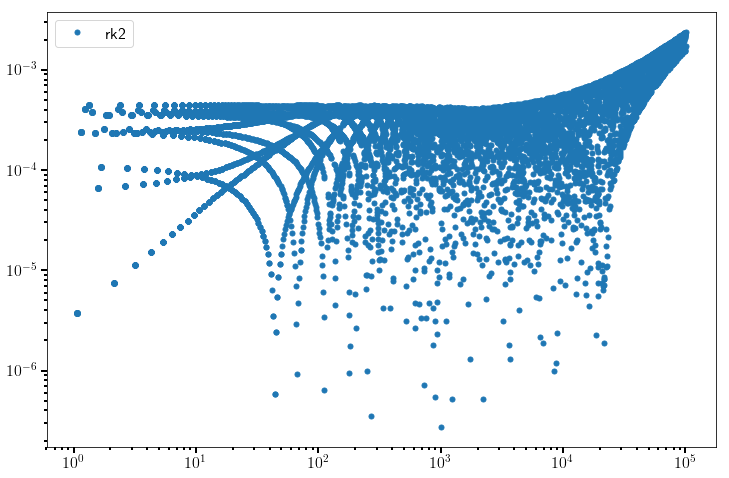

In [194]:
%%time
Eerr = {}
times = {}

for rebxintegrator in ['rk2']:
    sat = rebound.SimulationArchive(filename+'.sa', rebxfilename=filename+'.rebx')
    sim0 = sat[0]
    P = sim0.particles[1].P
    rebx = reboundx.Extras.from_file(sim0, filename+'.rebx')
    gr = rebx.get_effect("gr")
    E0 = rebx.gr_hamiltonian(sim0, gr)

    Eerr[rebxintegrator], times[rebxintegrator] = np.zeros(sat.nblobs), np.zeros(sat.nblobs)
    for i, sim in enumerate(sat):
        times[rebxintegrator][i] = sim.t/sim.particles[1].P
        E = rebx.gr_hamiltonian(sim, gr)
        try:
            Eerr[rebxintegrator][i] = np.abs((E-E0)/E0)
        except:
            Eerr[rebxintegrator][i] = 0
            
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times[rebxintegrator], Eerr[rebxintegrator], '.', label=rebxintegrator)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()